**Automatic License Plate Detection and Recognition**

MIS 5600

Deep Learning : Project


This project implements a **Faster R-CNN model** to detect vehicle license plates and extract text using EasyOCR. The goal is to build an end-to-end system that performs accurate object detection and OCR on real-world images.

In [ ]:
# Step 1 — Imports, device, and mount Google Drive

import os
import json
import time
import math
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Checking PyTorch / CUDA
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [ ]:
# Mount Google Drive (only once per session)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking the Dataset Root

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset"  # note the space at the end!

print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("Contents of DATA_ROOT:")
print(os.listdir(DATA_ROOT))

DATA_ROOT exists: True
Contents of DATA_ROOT:
['README.roboflow.txt', 'README.dataset.txt', 'train', 'valid', 'FasterRCNN_Results']


Step 2 : Reviewing Dataset and Annotations in COCO JSON Format
Checking inside the data structure - train and valid

In [ ]:
train_path = os.path.join(DATA_ROOT, "train")
valid_path = os.path.join(DATA_ROOT, "valid")

print("Train folder contents (sample):")
print(os.listdir(train_path)[:10])
print("\nValid folder contents (sample):")
print(os.listdir(valid_path)[:10])

# Locating COCO JSON in train/
train_json_path = os.path.join(train_path, "_annotations.coco.json")
print("\nCOCO JSON path:", train_json_path)
print("COCO JSON exists:", os.path.exists(train_json_path))

with open(train_json_path, "r") as f:
    coco = json.load(f)

print("Keys in COCO JSON:", coco.keys())
print("Number of images:", len(coco.get("images", [])))
print("Number of annotations:", len(coco.get("annotations", [])))


Train folder contents (sample):
['da84031eede66188_jpg.rf.6c1c4aee5b1fe350ccc63ef9a9ed11cf.jpg', 'd8d79b5517fb0a99_jpg.rf.d52c55f3b80c8c5a7aadf8fe4202eec3.jpg', 'd78b75ef330a1337_jpg.rf.e5f157a2ccf2c55687fb7393b5eca323.jpg', 'daac3a6c64a79bea_jpg.rf.18ddfc25396f28299d23296a9f57bfb2.jpg', 'd831f01e9879ca39_jpg.rf.eb5913df4c11cc9465e312b387b785df.jpg', 'd7386afc5e68ce96_jpg.rf.e57637282fb241e8bf6924bf77f7fe47.jpg', 'd957035fd4b234d8_jpg.rf.412fac2c82043eef4b09e13f8ea4f677.jpg', 'd85ebfc5c57541d2_jpg.rf.76929165df5596032e741c05c385a70c.jpg', 'd70f2e88449e4a02_jpg.rf.a60f005759e00446bf241b161e75d431.jpg', 'd99e77106a491e89_jpg.rf.5146c423962c50f52a5f61ece99f861e.jpg']

Valid folder contents (sample):
['0021af0b921af690_jpg.rf.a970736375e298cb19914eba9f38dff4.jpg', '0670b29f926e5259_jpg.rf.0b9860515f95125e1e601b42249a12a9.jpg', '04c084511ddf74f5_jpg.rf.7cb5b4737b50db80b0f93350a358f298.jpg', '0c5d3feefa49ac30_jpg.rf.7b1b510ac32955c0f0320fa06ef8bd71.jpg', '0cd29bcef8cf3a16_jpg.rf.2def6e5a0058

Step 3 : Define transforms and custom COCO dataset for Faster R-CNN


In [ ]:
def get_transform(train: bool):
    """
    Basic transforms:
    - RandomHorizontalFlip only for training
    - Convert to tensor
    """
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)


class CocoLicensePlateDataset(Dataset):
    """
    Custom dataset:
    - Reads images from img_dir
    - Uses COCO-style JSON annotations
    - Returns (image, target) in the format expected by Faster R-CNN
    """

    def __init__(self, img_dir: str, ann_path: str, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms

        with open(ann_path, "r") as f:
            coco = json.load(f)

        self.images_info = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco.get("categories", [])

        img_to_anns = defaultdict(list)
        for ann in self.annotations:
            img_to_anns[ann["image_id"]].append(ann)

        self.samples = []
        for img_info in self.images_info:
            file_name = img_info["file_name"]
            img_path = os.path.join(self.img_dir, file_name)
            if os.path.exists(img_path):
                image_id = img_info["id"]
                anns = img_to_anns.get(image_id, [])
                self.samples.append({
                    "img_path": img_path,
                    "image_id": image_id,
                    "anns": anns,
                    "width": img_info.get("width", None),
                    "height": img_info.get("height", None),
                })

        print(f"Initialized dataset for {img_dir}")
        print(f" → Found {len(self.samples)} images with annotations.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        sample = self.samples[idx]
        img_path = sample["img_path"]
        anns = sample["anns"]
        image_id = sample["image_id"]

        img = Image.open(img_path).convert("RGB")

        # Building boxes and labels from COCO-style annotations
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in anns:
            # COCO bbox format: [x, y, width, height]
            x, y, w, h = ann["bbox"]
            x1 = x
            y1 = y
            x2 = x + w
            y2 = y + h
            boxes.append([x1, y1, x2, y2])

            labels.append(1)
            areas.append(ann.get("area", w * h))
            iscrowd.append(ann.get("iscrowd", 0))

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": areas,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


def collate_fn(batch):
    """Collate function for detection models."""
    return tuple(zip(*batch))


Step 4 : Creating 80/20 train–validation split and DataLoaders

In [ ]:
ann_path = os.path.join(DATA_ROOT, "train", "_annotations.coco.json")
train_img_dir = os.path.join(DATA_ROOT, "train")

print("Annotation file exists:", os.path.exists(ann_path), ann_path)

full_dataset = CocoLicensePlateDataset(
    img_dir=train_img_dir,
    ann_path=ann_path,
    transforms=None
)

dataset_size = len(full_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

print(f"\nTotal images in full dataset: {dataset_size}")
print(f"Train split size (80%): {train_size}")
print(f"Valid split size (20%): {val_size}")

# Random split into train/val subsets
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, target

train_dataset = TransformedSubset(train_subset, get_transform(train=True))
val_dataset   = TransformedSubset(val_subset,   get_transform(train=False))

print("\nFinal dataset sizes (after split):")
print(" Train dataset:", len(train_dataset))
print(" Valid dataset:", len(val_dataset))

# DataLoaders
TRAIN_BATCH = 4
VAL_BATCH   = 4
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

images, targets = next(iter(train_loader))
print("\nSample batch from train_loader:")
print(" Batch size:", len(images))
print(" Image tensor shape:", images[0].shape)
print(" Boxes shape:", targets[0]["boxes"].shape)
print(" Labels:", targets[0]["labels"])


Annotation file exists: True /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/train/_annotations.coco.json
Initialized dataset for /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/train
 → Found 7337 images with annotations.

Total images in full dataset: 7337
Train split size (80%): 5870
Valid split size (20%): 1467

Final dataset sizes (after split):
 Train dataset: 5870
 Valid dataset: 1467

Sample batch from train_loader:
 Batch size: 4
 Image tensor shape: torch.Size([3, 1280, 1280])
 Boxes shape: torch.Size([3, 4])
 Labels: tensor([1, 1, 1])


Step 5 : Building Faster-RCNN Model

In [ ]:
# Faster R-CNN model

# Loading the pretrained Faster R-CNN
# This gives us the base model trained on COCO, which we will fine tune

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
print("Base Faster R-CNN model loaded.")

# COCO has 91 classes, but for this project we only need 2:
#    - class 0 = background
#    - class 1 = license plate

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print("Replaced box predictor head with num_classes =", num_classes)

# Move model to GPU (or CPU if GPU not available)

model.to(device)
print("Model moved to", device)

# showing how many parameters are trainable

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_params:,}")


Base Faster R-CNN model loaded.
Replaced box predictor head with num_classes = 2
Model moved to cuda
Trainable parameters: 41,076,761


**Faster R-CNN Model**

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
print("Base Faster R-CNN model loaded.")

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print("Replaced box predictor head with num_classes =", num_classes)

model.to(device)
print("Model moved to", device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_params:,}")

NUM_EPOCHS = 30
LR         = 0.005
MOMENTUM   = 0.9
WEIGHT_DECAY = 0.0005

BASE_DIR = os.path.join(
    "/content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset"
)
SAVE_DIR = os.path.join(BASE_DIR, "FasterRCNN_Results")
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving Faster R-CNN results to:", SAVE_DIR)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)
# LR scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
print(f"Training for {NUM_EPOCHS} epoch(s) with batch={TRAIN_BATCH}, workers={NUM_WORKERS}")



Step 6: Training Hyperparameters, Optimizer, and Scheduler


In [ ]:
NUM_EPOCHS = 30
LR         = 0.005
MOMENTUM   = 0.9
WEIGHT_DECAY = 0.0005

BASE_DIR = os.path.join(
    "/content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset"
)
SAVE_DIR = os.path.join(BASE_DIR, "FasterRCNN_Results")
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving Faster R-CNN results to:", SAVE_DIR)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)

# LR scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

print(f"Training for {NUM_EPOCHS} epoch(s) with batch={TRAIN_BATCH}, workers={NUM_WORKERS}")


Saving Faster R-CNN results to: /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/FasterRCNN_Results
Training for 30 epoch(s) with batch=4, workers=2


Step 7 : Train + Validate + Save Checkpoints and Loss Curve

In [ ]:
import pandas as pd

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "lr": []
}

best_val_loss = math.inf

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
    epoch_start = time.time()

    # TRAINING
    model.train()
    train_loss_sum = 0.0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_sum += loss_value

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Printing every 100 steps for epochs
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            print(f" [Train] Step {i+1}/{len(train_loader)} Loss: {loss_value:.4f}")

    avg_train_loss = train_loss_sum / max(1, len(train_loader))
    print(f"--> Average TRAIN loss: {avg_train_loss:.4f}")

    # VALIDATION
    val_loss_sum = 0.0
    model.train()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss_sum += losses.item()

    avg_val_loss = val_loss_sum / max(1, len(val_loader))
    print(f"--> Average VALIDATION loss: {avg_val_loss:.4f}")

    # Step LR scheduler
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"--> Learning rate after step: {current_lr:.6f}")

    # Saveing LAST checkpoint every epoch
    last_ckpt_path = os.path.join(SAVE_DIR, "fasterrcnn_last.pth")
    torch.save(model.state_dict(), last_ckpt_path)

    # Saving BEST (lowest val loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_ckpt_path = os.path.join(SAVE_DIR, "fasterrcnn_best.pth")
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"*** New BEST model saved (val_loss={best_val_loss:.4f}) ***")

    #  Log history
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["lr"].append(current_lr)

    epoch_time = time.time() - epoch_start
    print(f"Epoch time: {epoch_time:.1f} seconds")

print("\nTraining loop finished.")

# Saving training log (CSV)
log_df = pd.DataFrame(history)
csv_path = os.path.join(SAVE_DIR, "training_log.csv")
log_df.to_csv(csv_path, index=False)
print("Training log saved to:", csv_path)

# Plot & save loss curves
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"],  label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Faster R-CNN Training & Validation Loss")
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(SAVE_DIR, "loss_curves.png")
plt.savefig(loss_plot_path, bbox_inches="tight")
plt.close()
print("Loss curves saved to:", loss_plot_path)

print("\nAll Faster R-CNN results saved in:", SAVE_DIR)
print(" - fasterrcnn_last.pth")
print(" - fasterrcnn_best.pth")
print(" - training_log.csv")
print(" - loss_curves.png")



===== Epoch 1/30 =====
 [Train] Step 100/1468 Loss: 0.1628
 [Train] Step 200/1468 Loss: 0.1582
 [Train] Step 300/1468 Loss: 0.3415
 [Train] Step 400/1468 Loss: 0.2182
 [Train] Step 500/1468 Loss: 0.2223
 [Train] Step 600/1468 Loss: 0.3391
 [Train] Step 700/1468 Loss: 0.2129
 [Train] Step 800/1468 Loss: 0.1996
 [Train] Step 900/1468 Loss: 0.1549
 [Train] Step 1000/1468 Loss: 0.0754
 [Train] Step 1100/1468 Loss: 0.1492
 [Train] Step 1200/1468 Loss: 0.1892
 [Train] Step 1300/1468 Loss: 0.1644
 [Train] Step 1400/1468 Loss: 0.1888
 [Train] Step 1468/1468 Loss: 0.1133
--> Average TRAIN loss: 0.1874
--> Average VALIDATION loss: 0.1348
--> Learning rate after step: 0.005000
*** New BEST model saved (val_loss=0.1348) ***
Epoch time: 257.3 seconds

===== Epoch 2/30 =====
 [Train] Step 100/1468 Loss: 0.1435
 [Train] Step 200/1468 Loss: 0.2188
 [Train] Step 300/1468 Loss: 0.1521
 [Train] Step 400/1468 Loss: 0.2015
 [Train] Step 500/1468 Loss: 0.1308
 [Train] Step 600/1468 Loss: 0.1228
 [Train] St

Step 8 : Save final trained model weights to a single path

In [ ]:
final_model_path = os.path.join(DATA_ROOT, "fasterrcnn_lp_detector.pth")
os.makedirs(DATA_ROOT, exist_ok=True)

torch.save(model.state_dict(), final_model_path)
print(f"Model saved successfully to:\n{final_model_path}")


Model saved successfully to:
/content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/fasterrcnn_lp_detector.pth


Step 9 Reloading best model for inference

In [ ]:
best_ckpt_path = os.path.join(SAVE_DIR, "fasterrcnn_best.pth")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

state_dict = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Best Faster R-CNN model loaded and ready for prediction!")


Best Faster R-CNN model loaded and ready for prediction!


Step 10 : Helper Code to visualize Faster R-CNN predictions on a dataset sample



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import torch

def show_frcnn_prediction(
    model,
    dataset,
    idx: int = 0,
    device=None,
    score_threshold: float = 0.5,
    title_prefix: str = "Faster R-CNN Prediction"
):
    """
    Visualize Faster R-CNN predictions on a single image from a dataset.

    Args:
        model          : trained Faster R-CNN model (already on device, model.eval())
        dataset        : PyTorch Dataset (train_dataset or val_dataset)
        idx            : index of the image inside the dataset
        device         : torch.device or None (if None, auto-detect)
        score_threshold: keep only detections with score >= this value
        title_prefix   : text prefix for the matplotlib title
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    # Geting image + target
    img_tensor, target = dataset[idx]

    # Moving image to device and run inference
    img = img_tensor.to(device)
    with torch.no_grad():
        output = model([img])[0]

    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    # Filtering by score_threshold
    keep = scores >= score_threshold
    boxes = boxes[keep]
    scores = scores[keep]

    # # Rearranging the image so matplotlib can display it, and keep pixel values between 0 and 1
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_np)
    ax.axis("off")

    for (x1, y1, x2, y2), s in zip(boxes, scores):
        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor="lime",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            y1 - 5,
            f"{s:.2f}",
            fontsize=8,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none")
        )

    title = f"{title_prefix} (idx={idx}, detections={len(boxes)}, thr={score_threshold})"
    ax.set_title(title)
    plt.show()


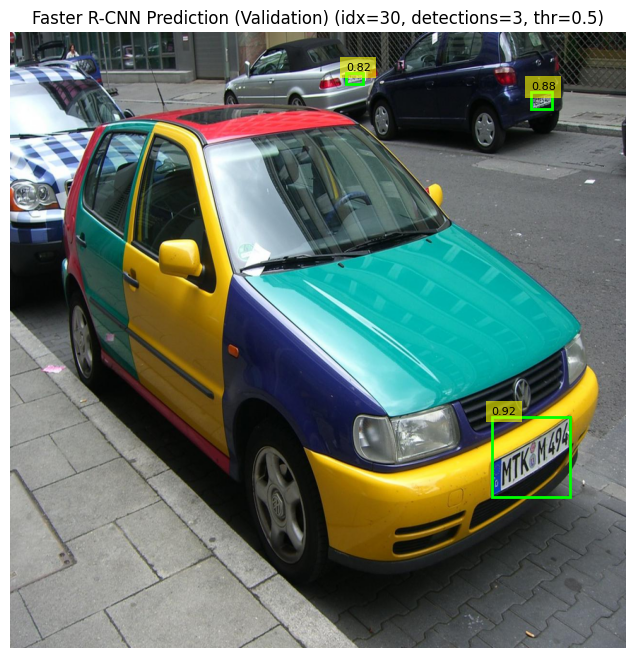

In [ ]:
show_frcnn_prediction(
    model=model,
    dataset=val_dataset,
    idx=30,
    device=device,
    score_threshold=0.5,
    title_prefix="Faster R-CNN Prediction (Validation)"
)

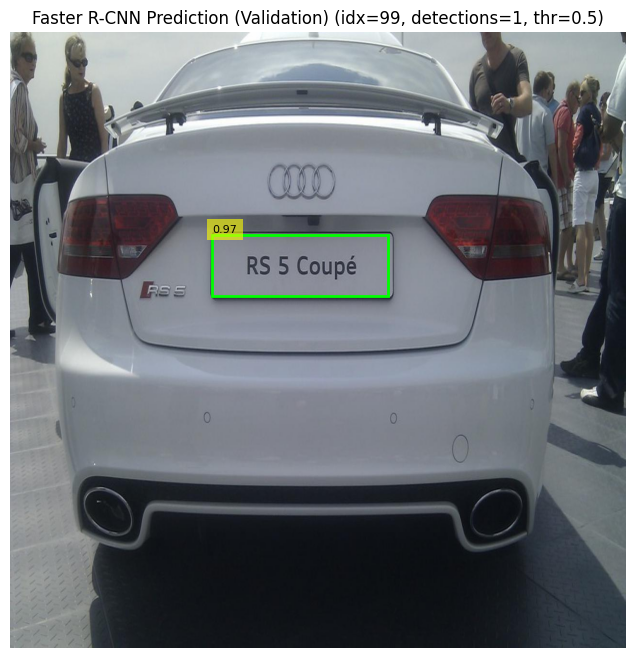

In [ ]:
show_frcnn_prediction(
    model=model,
    dataset=val_dataset,
    idx=99,
    device=device,
    score_threshold=0.5,
    title_prefix="Faster R-CNN Prediction (Validation)"
)

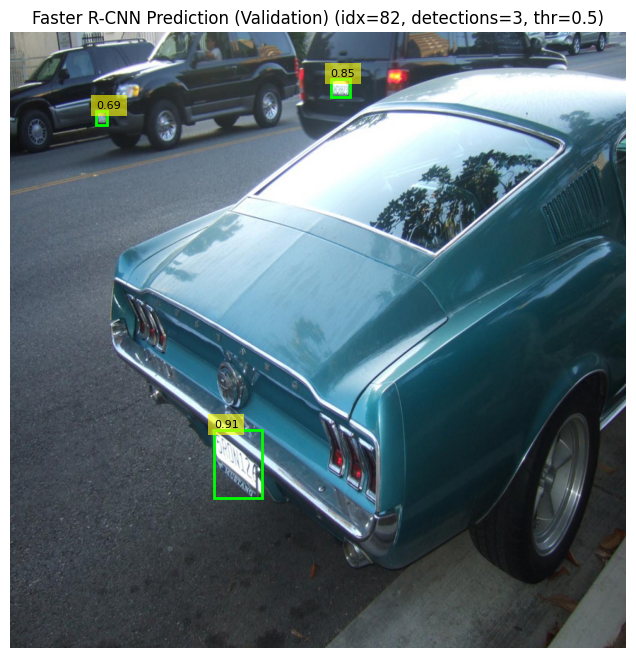

In [ ]:
show_frcnn_prediction(
    model=model,
    dataset=val_dataset,
    idx=82,
    device=device,
    score_threshold=0.5,
    title_prefix="Faster R-CNN Prediction (Validation)"
)

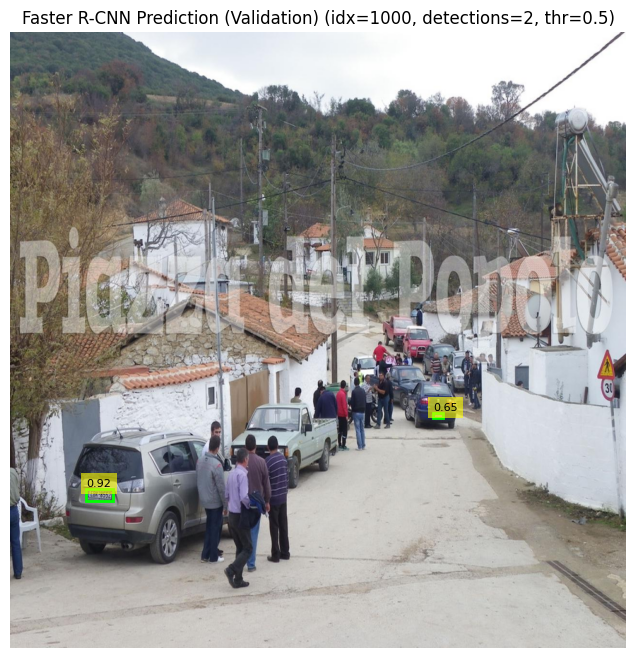

In [ ]:
show_frcnn_prediction(
    model=model,
    dataset=val_dataset,
    idx=1000,
    device=device,
    score_threshold=0.5,
    title_prefix="Faster R-CNN Prediction (Validation)"
)

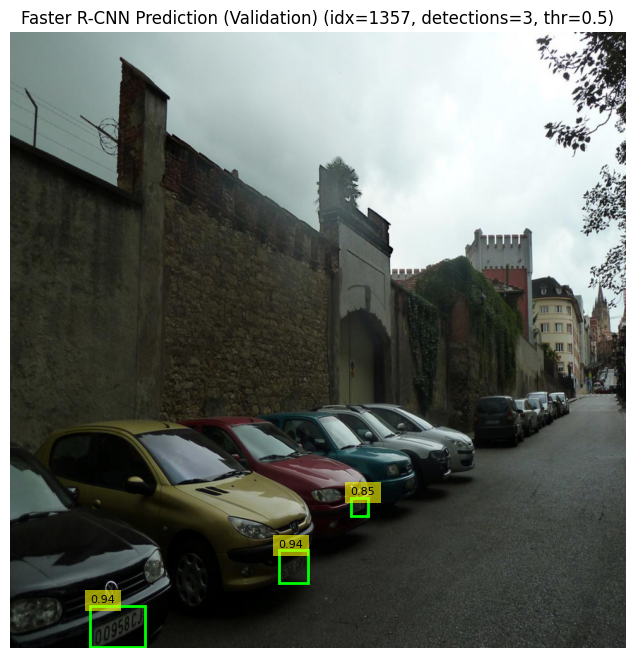

In [ ]:
show_frcnn_prediction(
    model=model,
    dataset=val_dataset,
    idx=1357,
    device=device,
    score_threshold=0.5,
    title_prefix="Faster R-CNN Prediction (Validation)"
)

Step 11 : Exporting Detections on a dataset subset to CSV

In [ ]:
import pandas as pd

def export_dataset_predictions_to_csv(
    model,
    dataset,
    csv_path: str,
    device=None,
    score_threshold: float = 0.5,
    max_samples: int = None
):
    """
    Run inference on a dataset (train or val) and export detections to CSV.

    CSV columns:
        index, image_id, box_x1, box_y1, box_x2, box_y2, score
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    num_samples = len(dataset)
    if max_samples is not None:
        num_samples = min(num_samples, max_samples)

    records = []

    for idx in range(num_samples):
        img_tensor, target = dataset[idx]
        img = img_tensor.to(device)

        with torch.no_grad():
            output = model([img])[0]

        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()

        keep = scores >= score_threshold
        boxes = boxes[keep]
        scores = scores[keep]

        image_id = int(target["image_id"].item())

        for (x1, y1, x2, y2), s in zip(boxes, scores):
            records.append({
                "index": idx,
                "image_id": image_id,
                "box_x1": float(x1),
                "box_y1": float(y1),
                "box_x2": float(x2),
                "box_y2": float(y2),
                "score": float(s),
            })

    df = pd.DataFrame(records)
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} detection rows to {csv_path}")


In [ ]:
val_csv_path = os.path.join(SAVE_DIR, "val_detections.csv")

export_dataset_predictions_to_csv(
    model=model,
    dataset=val_dataset,
    csv_path=val_csv_path,
    device=device,
    score_threshold=0.5,
    max_samples=50
)


Saved 78 detection rows to /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/FasterRCNN_Results/val_detections.csv


Step 12 : Installing EasyOCR and defining preprocessing + OCR helpers

In [ ]:
!pip install easyocr

import easyocr
import cv2
import re

# Initializing OCR reader (English, uppercase letters & digits)
reader = easyocr.Reader(['en'])

def preprocess_plate(plate_pil):
    """
    Convert plate crop to a high-contrast image for OCR:
    - grayscale
    - upscale
    - adaptive threshold
    """
    plate_np = np.array(plate_pil)
    gray = cv2.cvtColor(plate_np, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31, 5
    )
    return thresh

def ocr_plate(plate_pil, reader, conf_thresh=0.3):
    """
    Run EasyOCR on a preprocessed plate crop and return cleaned text + avg confidence.
    """
    plate_proc = preprocess_plate(plate_pil)
    results = reader.readtext(
        plate_proc,
        detail=1,
        paragraph=False,
        allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ :-'
    )

    if not results:
        return "", 0.0

    # Filtering by confidence
    filtered = [(text, conf) for (_, text, conf) in results if conf >= conf_thresh]
    if not filtered:
        filtered = [(text, conf) for (_, text, conf) in results]

    raw_text = " ".join(t for (t, _) in filtered)
    # Removing noisy characters
    clean_text = re.sub(r"[^0-9A-Z: -]", "", raw_text)
    avg_conf = sum(c for (_, c) in filtered) / len(filtered)

    return clean_text.strip(), avg_conf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 24.7 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Step 13 : License Plate Detection and Text Extraction ( Detect Plate + OCR frm an Image Path)

In [ ]:
def detect_and_read_plate(image_path, model, reader, device, score_thresh=0.5, show=True):

    model.eval()

    img_pil = Image.open(image_path).convert("RGB")

    img_tensor = get_transform(train=False)(img_pil).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes  = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    keep = scores >= score_thresh
    boxes_kept  = boxes[keep]
    scores_kept = scores[keep]

    if len(boxes_kept) == 0:
        print("No plate detected with score ≥", score_thresh)
        return None, None, None

    best_idx   = np.argmax(scores_kept)
    best_box   = boxes_kept[best_idx].astype(int)
    best_score = float(scores_kept[best_idx])
    x1, y1, x2, y2 = best_box

    plate_crop = img_pil.crop((x1, y1, x2, y2))

    plate_text, ocr_conf = ocr_plate(plate_crop, reader)

    if show:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        img_np = np.array(img_pil)
        ax[0].imshow(img_np)
        ax[0].axis("off")
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, color="red", linewidth=2)
        ax[0].add_patch(rect)
        ax[0].text(
            x1, y1 - 5, f"{best_score:.2f}",
            color="yellow", fontsize=12,
            bbox=dict(facecolor="black", alpha=0.5)
        )
        ax[0].set_title("Detected plate")

        ax[1].imshow(plate_crop)
        ax[1].axis("off")
        ax[1].set_title(f"OCR: {plate_text} (conf ~ {ocr_conf:.2f})")

        # Saving the detected images to Drive
        save_name = os.path.splitext(os.path.basename(image_path))[0] + "_det.jpg"
        save_path = os.path.join(SAVE_DET_DIR, save_name)
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print("Saved detection image to:", save_path)

        plt.show()

    print(f"Predicted plate text: '{plate_text}' (det score={best_score:.3f}, OCR conf≈{ocr_conf:.3f})")
    return plate_text, best_score, plate_crop


Saving the Detected Images into drive folder

In [ ]:
SAVE_DET_DIR = os.path.join(DATA_ROOT, "Detections")
os.makedirs(SAVE_DET_DIR, exist_ok=True)

print("Saving detection images to:", SAVE_DET_DIR)


Saving detection images to: /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/Detections


Good Detection

Saved detection image to: /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/Detections/fa897478280a2758_jpg.rf.4e93f682ce3a206d090158ab327dfd65_det.jpg


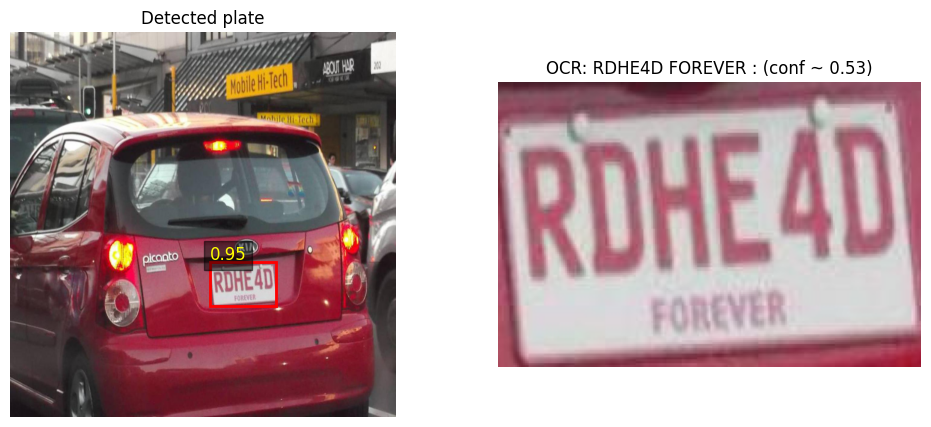

Predicted plate text: 'RDHE4D FOREVER :' (det score=0.950, OCR conf≈0.525)


In [ ]:
idx = 867
train_img_dir = os.path.join(DATA_ROOT, "train")
files = [f for f in os.listdir(train_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

plate_text, plate_score, plate_crop = detect_and_read_plate(
    os.path.join(train_img_dir, files[idx]),
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)


Good Detection

Saved detection image to: /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/Detections/e08424f3cd5f6dac_jpg.rf.34d970a546f6680cb7c8a369a852fb6d_det.jpg


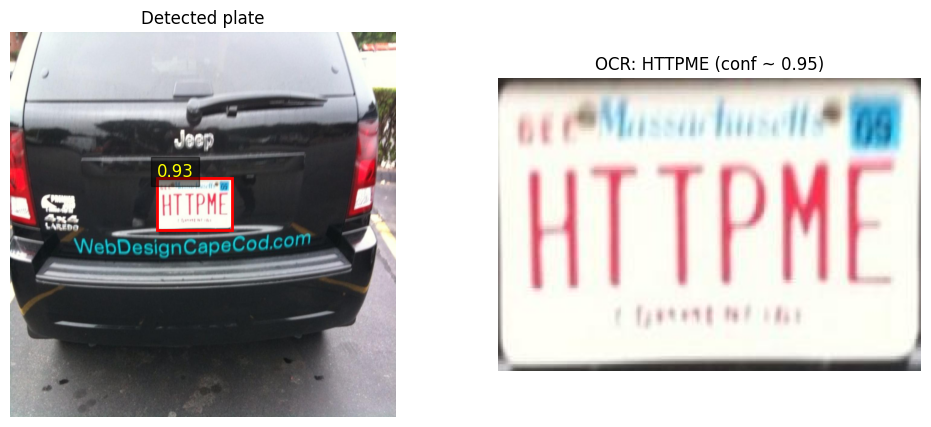

Predicted plate text: 'HTTPME' (det score=0.930, OCR conf≈0.948)


In [ ]:
idx = 97
train_img_dir = os.path.join(DATA_ROOT, "train")
files = [f for f in os.listdir(train_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

plate_text, plate_score, plate_crop = detect_and_read_plate(
    os.path.join(train_img_dir, files[idx]),
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)

Saved detection image to: /content/drive/MyDrive/MIS 5600 Deep Learning Project /Deep Learning Project Dataset/Detections/15ce4bbdaf876713_jpg.rf.4c2783746a63747c135729b7a1d4dcc1_det.jpg


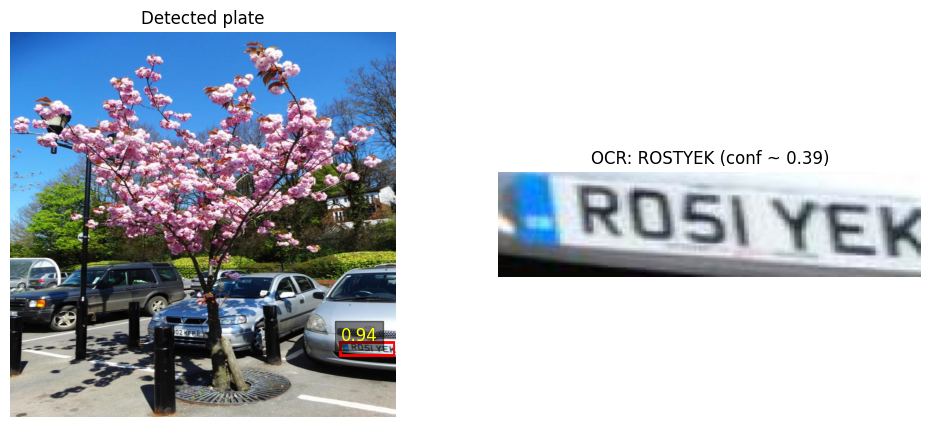

Predicted plate text: 'ROSTYEK' (det score=0.942, OCR conf≈0.387)


In [ ]:
idx = 6472
train_img_dir = os.path.join(DATA_ROOT, "train")
files = [f for f in os.listdir(train_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

plate_text, plate_score, plate_crop = detect_and_read_plate(
    os.path.join(train_img_dir, files[idx]),
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)

Weak detection result

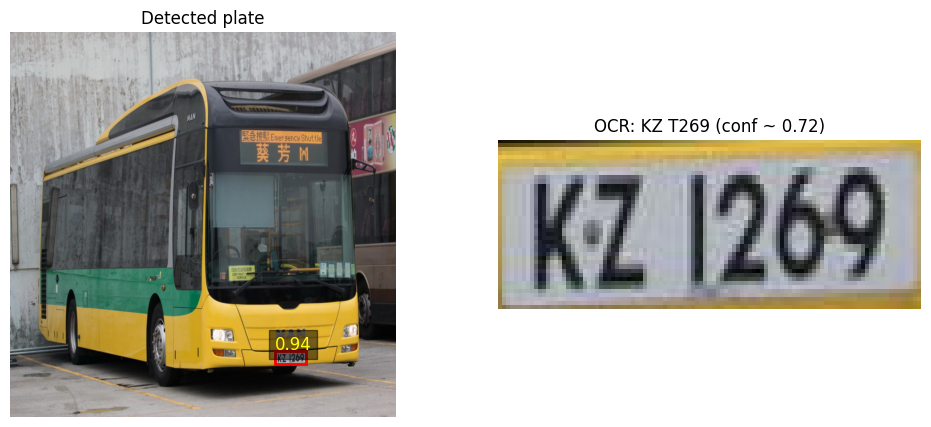

Predicted plate text: 'KZ T269' (det score=0.935, OCR conf≈0.721)


('KZ T269', 0.9350156784057617, <PIL.Image.Image image mode=RGB size=105x42>)

In [ ]:
example_img_path = os.path.join(train_img_dir, np.random.choice(os.listdir(train_img_dir)))

detect_and_read_plate(
    example_img_path,
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)


Good Detection



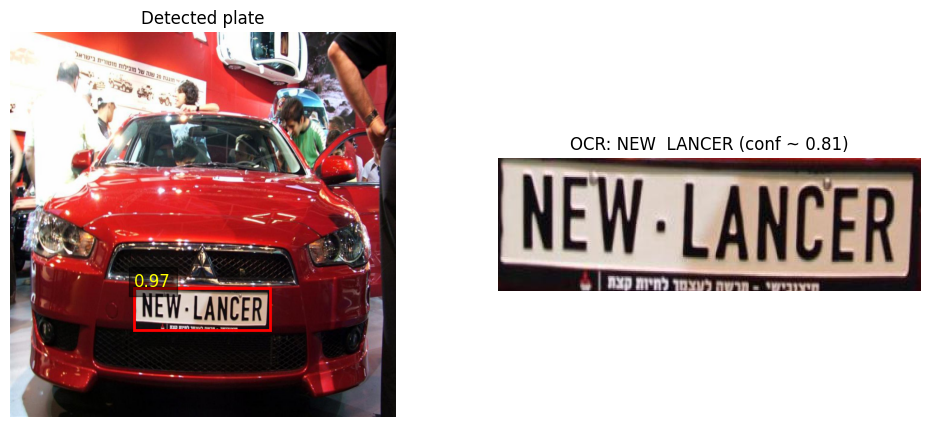

Predicted plate text: 'NEW  LANCER' (det score=0.971, OCR conf≈0.812)


('NEW  LANCER',
 0.9709529280662537,
 <PIL.Image.Image image mode=RGB size=450x141>)

In [ ]:
example_img_path = os.path.join(train_img_dir, np.random.choice(os.listdir(train_img_dir)))

detect_and_read_plate(
    example_img_path,
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)


Good Detection - blurred yet detected

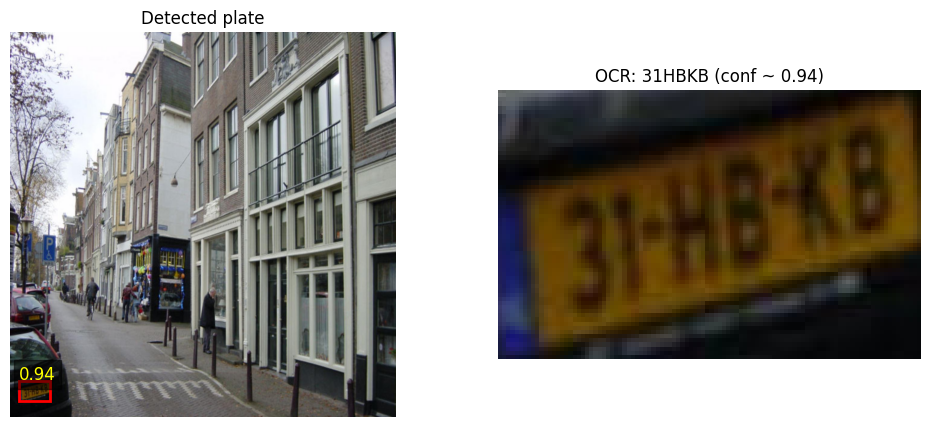

Predicted plate text: '31HBKB' (det score=0.939, OCR conf≈0.942)


('31HBKB', 0.9391697645187378, <PIL.Image.Image image mode=RGB size=102x65>)

In [ ]:
example_img_path = os.path.join(train_img_dir, np.random.choice(os.listdir(train_img_dir)))

detect_and_read_plate(
    example_img_path,
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)


Weak Detection

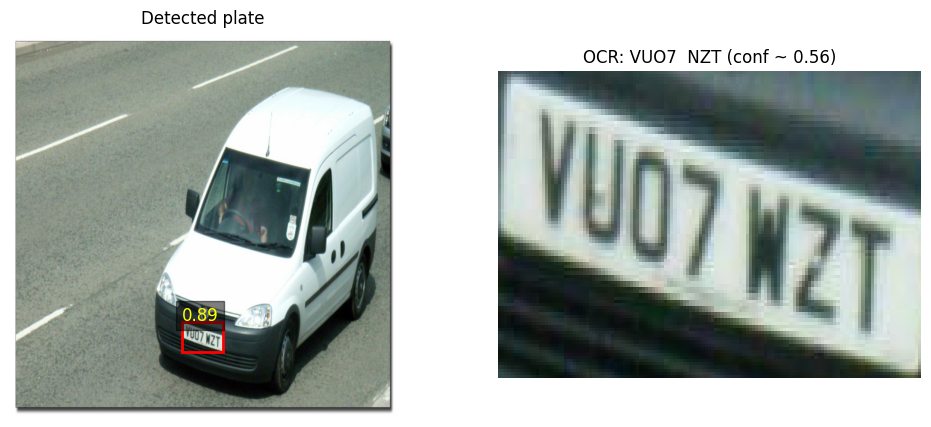

Predicted plate text: 'VUO7  NZT' (det score=0.893, OCR conf≈0.558)


('VUO7  NZT', 0.8930017352104187, <PIL.Image.Image image mode=RGB size=135x98>)

In [ ]:
example_img_path = os.path.join(train_img_dir, np.random.choice(os.listdir(train_img_dir)))

detect_and_read_plate(
    example_img_path,
    model=model,
    reader=reader,
    device=device,
    score_thresh=0.5,
    show=True
)


Step 14 : Evaluating Precision, Recall, F1, mean IoU on validation set


In [ ]:
def box_iou_single(box, boxes):
    """
    IoU between 1 box and N boxes.
    box:   Tensor [4]
    boxes: Tensor [N, 4]
    """
    if boxes.numel() == 0:
        return torch.zeros(0, device=box.device)

    x1 = torch.max(box[0], boxes[:, 0])
    y1 = torch.max(box[1], boxes[:, 1])
    x2 = torch.min(box[2], boxes[:, 2])
    y2 = torch.min(box[3], boxes[:, 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter_area = inter_w * inter_h

    area_box   = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = area_box + area_boxes - inter_area + 1e-6
    return inter_area / union


def evaluate_detector(model, data_loader, device,
                      iou_thresh=0.5, score_thresh=0.5, max_batches=None):
    """
    Simple detection evaluation:
    - Greedy matching of predictions to GT by IoU
    - Computes TP, FP, FN, Precision, Recall, F1, mean IoU of matches
    """
    model.eval()
    total_tp = 0
    total_fp = 0
    total_fn = 0
    iou_sum = 0.0
    iou_count = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            imgs = [img.to(device) for img in images]
            outputs = model(imgs)

            for out, tgt in zip(outputs, targets):
                gt_boxes = tgt["boxes"].to(device)   # [G, 4]
                pred_boxes = out["boxes"].to(device) # [P, 4]
                scores = out["scores"].to(device)    # [P]

                # Filter predictions by score
                keep = scores >= score_thresh
                pred_boxes = pred_boxes[keep]
                scores_f = scores[keep]

                matched_gt = set()

                for pb in pred_boxes:
                    if gt_boxes.numel() == 0:

                        total_fp += 1
                        continue

                    ious = box_iou_single(pb, gt_boxes)
                    max_iou, idx = torch.max(ious, dim=0)
                    idx = idx.item()
                    max_iou = max_iou.item()

                    if max_iou >= iou_thresh and idx not in matched_gt:
                        total_tp += 1
                        matched_gt.add(idx)
                        iou_sum += max_iou
                        iou_count += 1
                    else:
                        total_fp += 1

                total_fn += (gt_boxes.size(0) - len(matched_gt))

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall    = total_tp / (total_tp + total_fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou  = iou_sum / (iou_count + 1e-6)

    print("Detection evaluation (IoU ≥ {:.2f}, score ≥ {:.2f}):"
          .format(iou_thresh, score_thresh))
    print(f" True Positives : {total_tp}")
    print(f" False Positives: {total_fp}")
    print(f" False Negatives: {total_fn}")
    print(f" Precision      : {precision:.4f}")
    print(f" Recall         : {recall:.4f}")
    print(f" F1-score       : {f1:.4f}")
    print(f" Mean IoU (TPs) : {mean_iou:.4f}")

    return {
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_iou": mean_iou,
    }

# Running evaluation on validation set
metrics = evaluate_detector(
    model,
    val_loader,
    device,
    iou_thresh=0.5,
    score_thresh=0.5,
    max_batches=100
)


Detection evaluation (IoU ≥ 0.50, score ≥ 0.50):
 True Positives : 476
 False Positives: 114
 False Negatives: 76
 Precision      : 0.8068
 Recall         : 0.8623
 F1-score       : 0.8336
 Mean IoU (TPs) : 0.8060


In this project, a Faster R-CNN model was successfully trained and fine-tuned for automatic vehicle license-plate detection and OCR extraction. The model demonstrated strong detection capability on the validation set, achieving a Precision of 0.8068, Recall of 0.8623, F1-score of 0.8336, and a Mean IoU of 0.8060

This indicated it can reliably locate plates and interpret them correctly across many images, including those with blur, shadows, or slight angle changes.

Overall, The combination of Faster R-CNN and EasyOCR delivers strong, consistent accuracy for real-world license-plate recognition.
